# Determining the cost of cars

The service for selling used cars “Not a Bit, Not a Paint” is developing an application to attract new customers. Here you can quickly find out the market value of your car. We have historical data at our disposal: technical characteristics, configurations and prices of cars. You need to build a model to determine the cost.

The following are important to the customer:

- quality of prediction;
- prediction speed;
- studying time.

# Description of data

The data is in the file /datasets/autos.csv.

<b>Signs</b>

- DateCrawled — date the profile was downloaded from the database
- VehicleType - car body type
- RegistrationYear—year of vehicle registration
- Gearbox - gearbox type
- Power - power (hp)
- Model - car model
- Kilometer - mileage (km)
- RegistrationMonth—month of vehicle registration
- FuelType - fuel type
- Brand - car brand
- NotRepaired - whether the car was repaired or not
- DateCreated — date of creation of the profile
- NumberOfPictures — number of photos of the car
- PostalCode — postal code of the profile owner (user)
- LastSeen — date of the user’s last activity

<b>Target feature</b>

- Price — price (euros)

In [197]:
!pip install catboost
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Data preparation

In [198]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostRegressor
import lightgbm as lgb

import time
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./autos.csv')

print(df.info())
display(df.head())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<b>Let's work through the gaps</b>

In [199]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

All gaps in features with type object. Replace all blanks with 'unknown'

In [200]:
df_change = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

for i in df_change:
    df[i] = df[i].fillna('unknown')
    
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Let's remove columns that are not needed for training models

In [201]:
df = df.drop(columns = ['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'])

<b>Let's check for anomalies</b>

In [202]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


<AxesSubplot:>

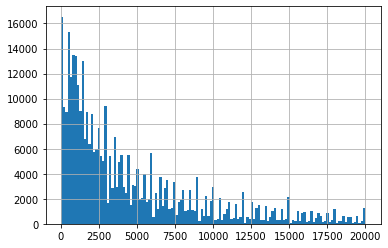

In [203]:
#Let's look at the price distribution

df['Price'].hist(bins='auto')

In [204]:
#Let's delete objects with zero value

df = df.query('Price != 0')

In [205]:
df['RegistrationYear'].value_counts()

2000    23072
1999    21995
2005    21524
2006    19679
2001    19654
        ...  
1949        1
2222        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 140, dtype: int64

In [206]:
#Let's delete RegistrationYear objects less than 1950 and more than 2022.

df = df.query('RegistrationYear < 2022')
df = df.query('RegistrationYear > 1950')

In [207]:
df['RegistrationYear'].value_counts()

2000    23072
1999    21995
2005    21524
2006    19679
2001    19654
        ...  
1957       13
1955       13
1951       10
1954        9
1952        8
Name: RegistrationYear, Length: 69, dtype: int64

<AxesSubplot:>

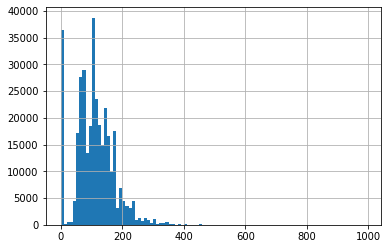

In [208]:
#Let's check the Power sign

df['Power'].hist(bins=range(0, 1000, 10))

In [209]:
#Let's delete objects with 0 power

df = df.query('Power != 0')

<AxesSubplot:>

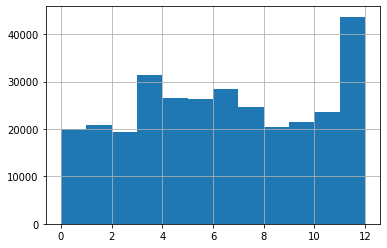

In [210]:
#Let's look at the RegistrationMonth distribution

df['RegistrationMonth'].hist(bins=12)

In [211]:
#Let's delete objects where 0 month

df = df.query('RegistrationMonth != 0')

<b>Convert to numbers</b>

In [212]:
ord_enc = OrdinalEncoder()
df[['NotRepaired', 'Gearbox', 'VehicleType', 'Model', 'FuelType', 'Brand']] = ord_enc.fit_transform(df[['NotRepaired', 'Gearbox', 'VehicleType', 'Model', 'FuelType', 'Brand']])

In [213]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
1,18300,2.0,2011,1.0,190,227.0,125000,5,2.0,1.0,2.0,66954
2,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0,90480
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0,91074
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,60437
5,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,2.0,33775


Let's divide df into 3 samples. Test, training and validation.

In [214]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12345)
df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=12345)
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']
features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price']
features_test = df_test.drop(['Price'], axis=1)
target_test = df_test['Price']

In [215]:
print('Генеральная выборка -', df.shape[0])
print('Обучающая выборка -', features_train.shape[0])
print('Валидационная выборка -', features_valid.shape[0])
print('Тестовая выборка -', features_test.shape[0])

Генеральная выборка - 287060
Обучающая выборка - 172236
Валидационная выборка - 57412
Тестовая выборка - 57412


The signs contain different scales. We standardize them using StandardScaler

In [216]:
numeric = features_train.columns

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

display(features_train.head())

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
215306,1.409624,0.980651,0.441085,-0.012982,0.051625,-0.081113,0.781557,0.635579,1.291978,-0.497904,-0.505830
5842,0.994480,2.165291,0.441085,0.151776,0.051625,0.598311,0.184215,0.635579,1.291978,-0.497904,-0.034522
174543,-1.911524,0.388331,0.441085,0.039976,1.520491,0.598311,0.482886,-1.479857,1.291978,-0.497904,0.982774
279444,1.409624,-1.092468,0.441085,-0.065940,0.738011,0.598311,1.677571,-1.479857,-0.054988,-0.497904,0.124550
212039,-0.250950,1.128731,-1.908911,0.828463,-0.730854,-2.119384,1.378900,-1.479857,-0.054988,-0.497904,-1.599358


<b>Output</b>

We reviewed the data and filled in the necessary blanks.

Let's move on to training models

## Model training

<b>CatBoost</b>

In [217]:
model_cb = CatBoostRegressor(random_state = 12345, iterations = 100)
parameters_cb = {'depth': range(6, 11), 'learning_rate': [0.001, 0.01, 0.05, 0.1]}
search_cb = RandomizedSearchCV(model_cb, parameters_cb, cv = 5, n_jobs = -1, random_state = 12345)
search_cb.fit(features_train, target_train, verbose = 100)
best_cb = search_cb.best_estimator_
predict_cb_valid = best_cb.predict(features_valid)
rmse_cb_valid = mean_squared_error(target_valid, predict_cb_valid)**0.5
print('Качество модели CatBoost на валидационной выборке:', rmse_cb_valid)

0:	learn: 4305.8806132	total: 33.7ms	remaining: 3.33s
99:	learn: 1712.9877455	total: 2.44s	remaining: 0us
Качество модели CatBoost на валидационной выборке: 1758.3141414318668


<b>LightGBM</b>

In [218]:
model_lgb = lgb.LGBMRegressor(random_state=12345)
parameters_lgb = {'max_depth': (6, 11), 'learning_rate': [0.001, 0.01, 0.05, 0.1], 'n_estimators': range(100, 501, 50)}
search_lgb = RandomizedSearchCV(model_lgb, parameters_lgb, cv = 5, n_jobs = -1, random_state = 12345)
search_lgb.fit(features_train, target_train)
best_lgb = search_lgb.best_estimator_
predict_lgb_valid = best_lgb.predict(features_valid)
rmse_lgb_valid = mean_squared_error(target_valid, predict_lgb_valid)**0.5
print('Качество модели LighGBM на валидационной выборке:', rmse_lgb_valid)

Качество модели LighGBM на валидационной выборке: 1676.1467079539314


## Model analysis

<b>CatBoost</b>

In [219]:
%%time
start_cb_fit = time.time()
best_cb.fit(features_train, target_train, verbose = 100)
end_cb_fit = time.time()
time_cb_fit = end_cb_fit - start_cb_fit
start_cb_predict = time.time()
predict_cb_test = best_cb.predict(features_test)
end_cb_predict = time.time()
time_cb_predict = end_cb_predict - start_cb_predict
rmse_cb_test = mean_squared_error(target_test, predict_cb_test)**0.5
print('Качество модели CatBoost на тестовой выборке:', rmse_cb_test)

0:	learn: 4305.8806132	total: 27.3ms	remaining: 2.7s
99:	learn: 1712.9877455	total: 2.85s	remaining: 0us
Качество модели CatBoost на тестовой выборке: 1764.186348743676
CPU times: user 9.28 s, sys: 204 ms, total: 9.48 s
Wall time: 2.98 s


<b>LightGBM</b>

In [220]:
%%time
start_lgb_fit = time.time()
best_lgb.fit(features_train, target_train)
end_lgb_fit = time.time()
time_lgb_fit = end_lgb_fit - start_lgb_fit
start_lgb_predict = time.time()
predict_lgb_test = best_lgb.predict(features_test)
end_lgb_predict = time.time()
time_lgb_predict = end_lgb_predict - start_lgb_predict

rmse_lgb_test = mean_squared_error(target_test, predict_lgb_test)**0.5
print('Качество модели CatBoost:', rmse_lgb_test)

Качество модели CatBoost: 1672.6872899400298
CPU times: user 6.99 s, sys: 20.5 ms, total: 7.01 s
Wall time: 1.97 s


## Final conclusion

The LightGBM model is most suitable for our project. Using it we get RSME - 1672, total: 5.67 s, Wall time: 1.48 s